In [113]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import new_interf
from datetime import datetime, timedelta
import scipy.optimize

In [121]:
ugradio.timing.lst

<function ugradio.timing.lst(jd=None, lon=-122.257063)>

In [67]:
L = ugradio.nch.lat # latitude


In [122]:
sun_data = pd.read_csv('sun_data2.csv')
sun_trunc = sun_data[2100:]
sun_volts = np.array(sun_trunc['Voltages'])
sun_times = np.array(sun_trunc['Times'])
#print(datetime.utcfromtimestamp(moon_times[0]).strftime('%Y-%m-%d %H:%M:%S'), "in UTC")
def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    tJ= ugradio.timing.julian_date(unix_time)
    return time.strftime('%Y-%m-%d %H:%M:%S'), tJ
t,tJ = utc_to_local(sun_times[2100])
#lst = ugradio.timing.lst(tJ)
print(t, "local time", tJ, "Julian time")

#print(moon_times[0], "time of observation in bullshit unix")
sun_times -= sun_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = sun_times[1] - sun_times[0]  # this is the time step between samples
sun_volts-= sun_volts.mean()

ValueError: Column year failed to convert: invalid literal for int() with base 10: '<!'

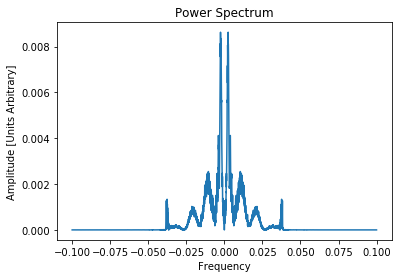

In [84]:
voltage_spectrum = np.fft.fft(sun_volts)
voltage_spectrum[0] = 0 # this is the same as subtracting the mean in the timeseries data 
power_spectrum = np.abs(voltage_spectrum)**2
frequencies = np.fft.fftfreq(len(power_spectrum), dt)

plt.figure()
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude [Units Arbitrary]")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(power_spectrum)) # shifting the arrays to read correctly
plt.show()

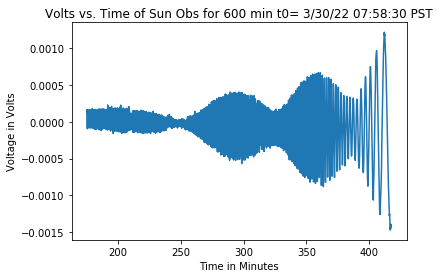

In [80]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 07:58:30 PST")
plt.plot(sun_times[2100:]/60, sun_volts[2100:])
plt.show()

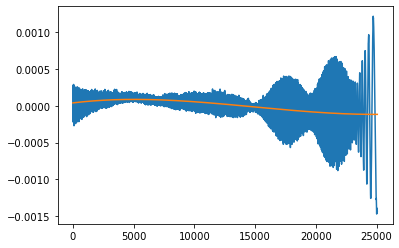

In [81]:
plt.figure()
plt.plot(sun_times, sun_volts)
p= np.polyfit(sun_times, sun_volts, 3)
fit = np.polyval(p, sun_times)
sun_volts-=fit
plt.plot(sun_times, fit)
plt.show()

In [82]:
RA_deg, dec= ugradio.coord.sunpos(tJ) # wants julian date and it will return the RA and Dec
print(RA_deg, "RA in degrees")
#arc_dec= 10.6/60 #converting arc min to degrees 
#arc_dec
#dec = -16 - arc_dec
print(dec, "Dec in degrees")

precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
print("precess_ra is", precess_ra, "precess_dec is", precess_dec )
RA = np.radians(precess_ra)
Dec = np.radians(precess_dec)
print("RA is", RA, "Dec", Dec )

9.061085302330332 RA in degrees
3.9050260039516616 Dec in degrees
precess_ra is 9.055708152955468 precess_dec is 3.9027359229886667
RA is 0.1580519233687672 Dec 0.06811559169201209


In [120]:
# guessing values for nu tau g to fit for the fringe amplitude

#guesses in meters
Bew = 20
Bns = 0
L = ugradio.nch.lat # latitude
wl = .0250  # wavelength in meters
# ntg = nu tao g
hs = RA - lst
ntg = (Bew / wl *np.cos(Dec)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec))*np.cos(hs)
ntg_trunc = ntg[3900:4650]
print(ntg)

# now this needs to go into eq 12 (f is a function of A and B)


IndexError: invalid index to scalar variable.

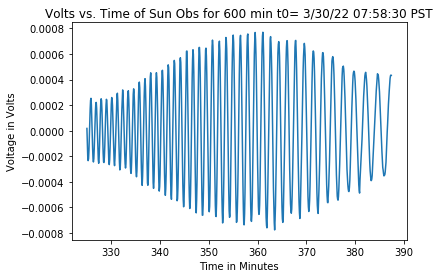

In [109]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 07:58:30 PST")
plt.plot(sun_times[3900:4650]/60, sun_volts[3900:4650])
plt.show()

In [119]:
F = sun_volts[3900:4650]
def model(A,B):
    return A*np.cos(2*np.pi*ntg) + B*np.sin(2*np.pi*ntg) 
    
def chisq(A,B):
    stuff = model(A,B)
    return np.sum((stuff-F)**2)

res = scipy.optimize.minimize(chisq, np.array([.0006,.0004]))
A, B = res.x
print(res.success, res.message)

ValueError: operands could not be broadcast together with shapes (2,) (750,) 

In [ ]:
#guesses in meters
Bew_array = np.linspace((13,23,20))
Bns_array = np.linspace((0,5,20))
L = ugradio.nch.lat # latitude
wl = .0250  # wavelength in meters
# ntg = nu tao g
hs = RA - lst
chisq_array = np.empty((20,20))
i = 0
j = 0

for Bew in Bew_array:
    for Bns in Bns_array:
        ntg = (Bew / wl *np.cos(Dec)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec))*np.cos(hs)
        ntg_trunc = ntg[3900:4650]
        def model(A,B):
            return A*np.cos(2*np.pi*ntg) + B*np.sin(2*np.pi*ntg) 

        def chisq(A,B):
            stuff = model(A,B)
            return np.sum((stuff-F)**2)

        res = scipy.optimize.minimize(chisq, np.array([.0006,.0004]))
        A, B = res.x
        chisq_array[i,j] = chisq(A,B)
        j+=1
    i+=1

In [ ]:
plt.figure()
plt.imshow(chisq_array,extend = [0,5,23,13])
plt.colorbar()
plt.show()